# Tidsserie-til-LLM Utforsknings-Pipeline

Denne notebooken demonstrerer hvordan tidsseriedata kan prosesseres og overleveres til en LLM som strukturerte sammendrag.

## Overordnet flyt:
1. **Syntetisk tidsserie** - Genererer data med trend, sesongvariasjon og anomalier
2. **Deterministisk prosessering** - Resampling, aggregering, change point detection
3. **TSFRESH feature extraction** - Automatisk ekstraksjon av relevante features
4. **Strukturert sammendrag** - Konverterer funn til tekst/JSON
5. **LLM-integrasjon** - Sender til OpenAI for naturlig språk-forklaring

## Oppsett og imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from openai import OpenAI
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Sett opp plotting stil
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Alle biblioteker importert!")

Alle biblioteker importert!


---
## Seksjon 1: Generer syntetisk tidsserie

Vi lager en realistisk tidsserie med:
- **Trend**: Gradvis økning over tid
- **Sesongvariasjon**: Ukentlige og daglige mønstre
- **Støy**: Tilfeldig variasjon
- **Anomalier**: Noen uventede hendelser

In [3]:
def generate_synthetic_timeseries(
    n_days: int = 90,
    samples_per_day: int = 24,
    seed: int = 42
) -> pd.DataFrame:
    """
    Genererer syntetisk tidsseriedata som simulerer f.eks. strømforbruk eller nettverkstrafikk.
    
    Parametere:
    -----------
    n_days : int
        Antall dager med data
    samples_per_day : int
        Antall målinger per dag (24 = timesdata)
    seed : int
        Random seed for reproduserbarhet
    
    Returns:
    --------
    pd.DataFrame med kolonner: timestamp, value, id
    """
    np.random.seed(seed)
    
    n_samples = n_days * samples_per_day
    start_date = datetime(2025, 1, 1)
    
    # Lag tidsstempler
    timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]
    
    # Basisverdi
    base_value = 100
    
    # 1. Trend-komponent (gradvis økning)
    trend = np.linspace(0, 20, n_samples)
    
    # 2. Sesongvariasjoner
    # Daglig mønster (høyere på dagtid)
    hour_of_day = np.array([t.hour for t in timestamps])
    daily_pattern = 15 * np.sin(2 * np.pi * (hour_of_day - 6) / 24)
    
    # Ukentlig mønster (lavere i helger)
    day_of_week = np.array([t.weekday() for t in timestamps])
    weekly_pattern = np.where(day_of_week >= 5, -10, 5)  # Helg = lavere
    
    # 3. Støy
    noise = np.random.normal(0, 5, n_samples)
    
    # 4. Kombiner komponenter
    values = base_value + trend + daily_pattern + weekly_pattern + noise
    
    # 5. Legg til anomalier (5 stykker)
    anomaly_indices = np.random.choice(n_samples, size=5, replace=False)
    anomaly_values = np.random.choice([50, -40, 60, -35, 45])  # Store avvik
    for idx, anomaly in zip(anomaly_indices, [50, -40, 60, -35, 45]):
        values[idx] += anomaly
    
    # Lag DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'value': values,
        'id': 1  # Påkrevd for tsfresh
    })
    
    return df, anomaly_indices

# Generer data
df_raw, anomaly_indices = generate_synthetic_timeseries(n_days=90)

print(f"Datasett generert:")
print(f"  - Periode: {df_raw['timestamp'].min()} til {df_raw['timestamp'].max()}")
print(f"  - Antall datapunkter: {len(df_raw)}")
print(f"  - Anomalier plassert ved indekser: {sorted(anomaly_indices)}")
print(f"\nFørste rader:")
df_raw.head()

Datasett generert:
  - Periode: 2025-01-01 00:00:00 til 2025-03-31 23:00:00
  - Antall datapunkter: 2160
  - Anomalier plassert ved indekser: [23, 256, 1094, 1165, 1977]

Første rader:


,timestamp,value,id
0,2025-01-01 00:00:00,92.483571,1
1,2025-01-01 01:00:00,89.829055,1
2,2025-01-01 02:00:00,95.266589,1
3,2025-01-01 03:00:00,102.036338,1
4,2025-01-01 04:00:00,96.366287,1


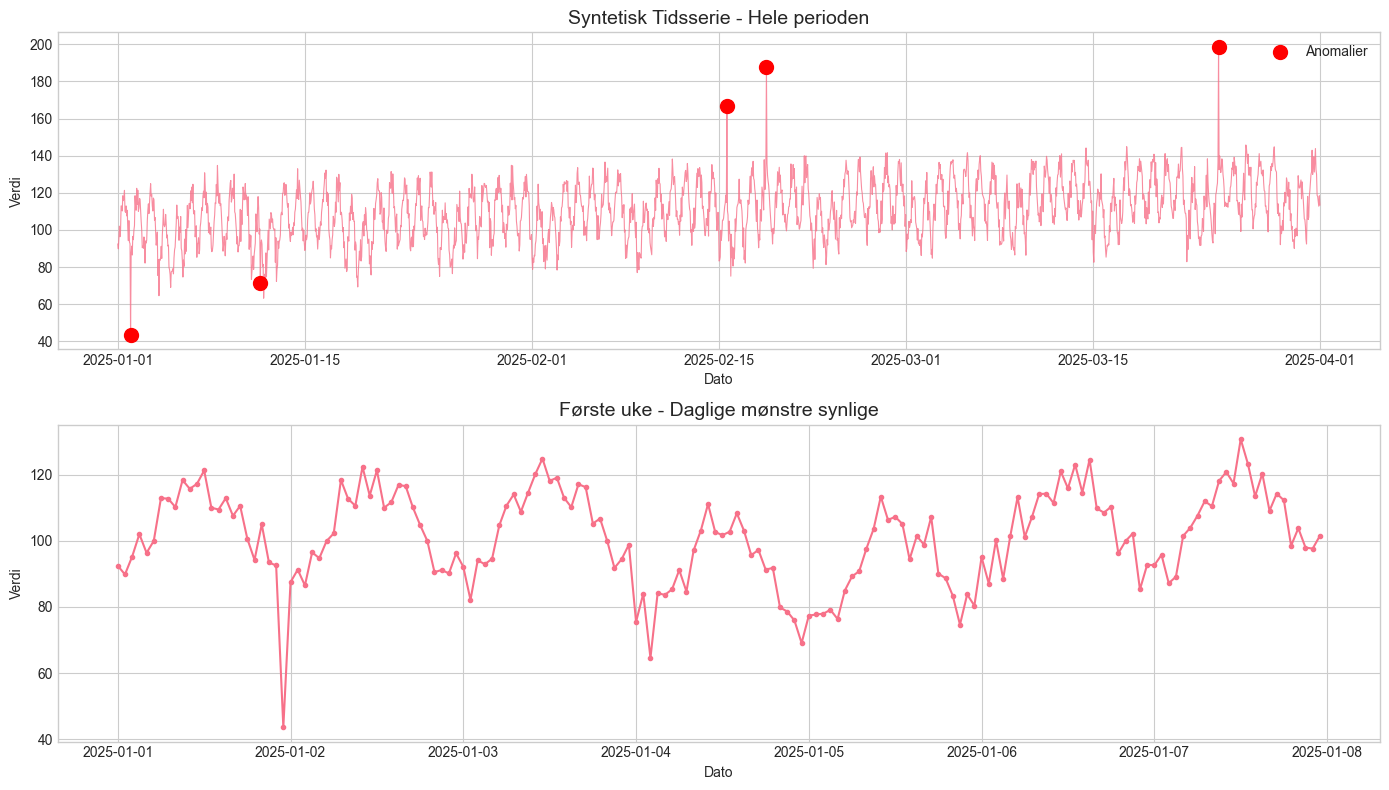


✓ Visualisering viser tydelig trend, daglige mønstre og anomalier (røde prikker)


In [4]:
# Visualiser rå tidsserie
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Hele tidsserien
ax1 = axes[0]
ax1.plot(df_raw['timestamp'], df_raw['value'], linewidth=0.8, alpha=0.8)
ax1.scatter(df_raw.iloc[anomaly_indices]['timestamp'], 
            df_raw.iloc[anomaly_indices]['value'], 
            color='red', s=100, zorder=5, label='Anomalier')
ax1.set_title('Syntetisk Tidsserie - Hele perioden', fontsize=14)
ax1.set_xlabel('Dato')
ax1.set_ylabel('Verdi')
ax1.legend()

# En uke med data for å vise daglig mønster
one_week = df_raw[df_raw['timestamp'] < df_raw['timestamp'].min() + timedelta(days=7)]
ax2 = axes[1]
ax2.plot(one_week['timestamp'], one_week['value'], linewidth=1.5, marker='o', markersize=3)
ax2.set_title('Første uke - Daglige mønstre synlige', fontsize=14)
ax2.set_xlabel('Dato')
ax2.set_ylabel('Verdi')

plt.tight_layout()
plt.show()

print("\n✓ Visualisering viser tydelig trend, daglige mønstre og anomalier (røde prikker)")

---
## Seksjon 2: Deterministisk prosessering (før LLM)

Her utfører vi klassisk tidsserieanalyse:
- Resampling til daglig oppløsning
- Beregning av rullende statistikk
- Change point detection
- Anomalideteksjon med Z-score

In [5]:
# 2.1 Resampling til ulike oppløsninger
df_indexed = df_raw.set_index('timestamp')

# Daglig aggregering
df_daily = df_indexed['value'].resample('D').agg(['mean', 'std', 'min', 'max', 'count'])
df_daily.columns = ['daily_mean', 'daily_std', 'daily_min', 'daily_max', 'sample_count']

# Ukentlig aggregering
df_weekly = df_indexed['value'].resample('W').agg(['mean', 'std', 'min', 'max'])
df_weekly.columns = ['weekly_mean', 'weekly_std', 'weekly_min', 'weekly_max']

print("Daglig aggregering:")
print(df_daily.head(10))
print(f"\nTotalt {len(df_daily)} dager med data")

Daglig aggregering:
            daily_mean  daily_std  daily_min   daily_max  sample_count
timestamp                                                             
2025-01-01  102.701673  15.696150  43.600433  121.320974            24
2025-01-02  104.014074  11.493096  86.495503  122.418066            24
2025-01-03  106.035317  11.367366  82.149826  124.913162            24
2025-01-04   90.110603  12.537898  64.596396  111.139462            24
2025-01-05   91.248345  11.933747  74.633843  113.403247            24
2025-01-06  105.769830  11.238260  85.287627  124.606853            24
2025-01-07  107.499086  11.341920  87.177343  130.773986            24
2025-01-08  106.809641  13.414892  88.307971  134.747908            24
2025-01-09  108.469307  12.441006  86.070283  130.082025            24
2025-01-10  106.625277  12.035128  88.136800  125.008229            24

Totalt 90 dager med data


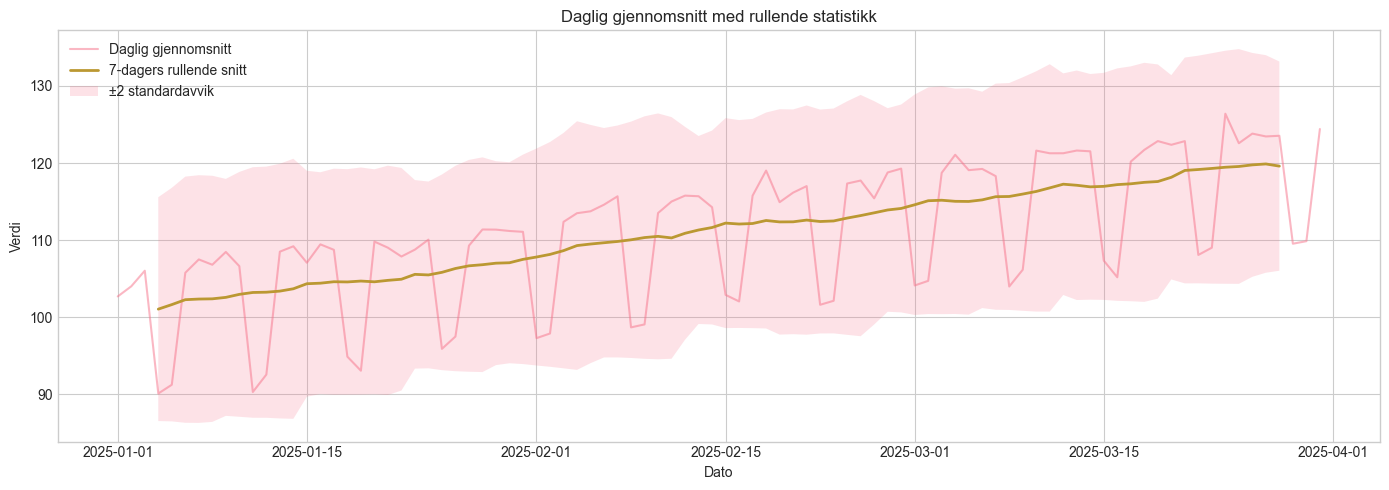

In [6]:
# 2.2 Rullende statistikk
window_size = 7  # 7 dager

df_daily['rolling_mean'] = df_daily['daily_mean'].rolling(window=window_size, center=True).mean()
df_daily['rolling_std'] = df_daily['daily_mean'].rolling(window=window_size, center=True).std()

# Visualiser rullende statistikk
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_daily.index, df_daily['daily_mean'], alpha=0.5, label='Daglig gjennomsnitt')
ax.plot(df_daily.index, df_daily['rolling_mean'], linewidth=2, label=f'{window_size}-dagers rullende snitt')
ax.fill_between(df_daily.index, 
                df_daily['rolling_mean'] - 2*df_daily['rolling_std'],
                df_daily['rolling_mean'] + 2*df_daily['rolling_std'],
                alpha=0.2, label='±2 standardavvik')
ax.set_title('Daglig gjennomsnitt med rullende statistikk')
ax.set_xlabel('Dato')
ax.set_ylabel('Verdi')
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
# 2.3 Change Point Detection (enkel CUSUM-basert metode)
def detect_change_points(values: np.ndarray, threshold: float = 2.0) -> list:
    """
    Enkel change point detection basert på kumulativ sum av avvik.
    """
    mean_val = np.mean(values)
    std_val = np.std(values)
    
    # Normaliser verdier
    normalized = (values - mean_val) / std_val
    
    # Kumulativ sum
    cusum = np.cumsum(normalized)
    
    # Finn punkter hvor endringen er stor
    diff = np.abs(np.diff(cusum))
    change_points = np.where(diff > threshold)[0]
    
    return change_points.tolist()

# Finn change points i daglige data
daily_values = df_daily['daily_mean'].dropna().values
change_points = detect_change_points(daily_values, threshold=1.5)

print(f"Potensielle change points funnet: {len(change_points)}")
if change_points:
    change_dates = df_daily.index[change_points]
    print(f"Datoer: {change_dates.tolist()[:5]}...")  # Vis første 5

Potensielle change points funnet: 11
Datoer: [Timestamp('2025-01-03 00:00:00'), Timestamp('2025-01-04 00:00:00'), Timestamp('2025-01-10 00:00:00'), Timestamp('2025-01-11 00:00:00'), Timestamp('2025-01-17 00:00:00')]...


Anomalier detektert: 13
Faktiske anomalier injisert: 5

Detekterte anomalier:
               timestamp       value   z_score
23   2025-01-01 23:00:00   43.600433 -4.486781
74   2025-01-04 02:00:00   64.596396 -3.086635
95   2025-01-04 23:00:00   69.073575 -2.788068
240  2025-01-11 00:00:00   73.260648 -2.508847
256  2025-01-11 16:00:00   71.206024 -2.645863
262  2025-01-11 22:00:00   63.230332 -3.177733
263  2025-01-11 23:00:00   72.825488 -2.537866
265  2025-01-12 01:00:00   71.727037 -2.611118
285  2025-01-12 21:00:00   72.273070 -2.574705
431  2025-01-18 23:00:00   69.307541 -2.772466
1094 2025-02-15 14:00:00  166.787903  3.728153
1165 2025-02-18 13:00:00  187.479683  5.108014
1977 2025-03-24 09:00:00  198.658268  5.853474


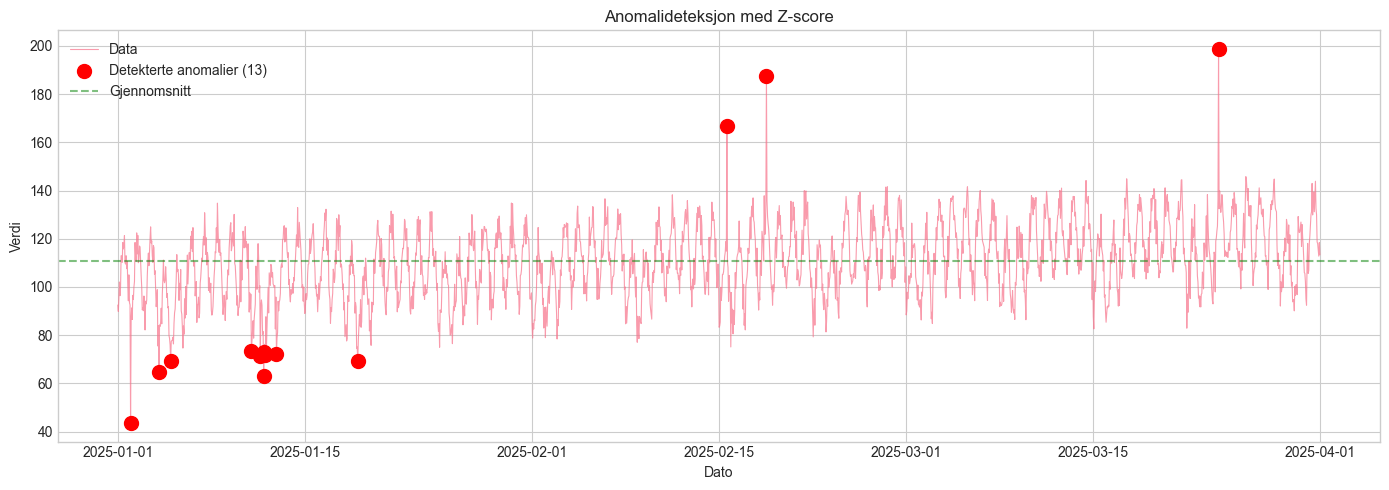

In [8]:
# 2.4 Anomalideteksjon med Z-score
def detect_anomalies_zscore(values: pd.Series, threshold: float = 3.0) -> pd.Series:
    """
    Detekterer anomalier basert på Z-score.
    Verdier med |z-score| > threshold klassifiseres som anomalier.
    """
    mean_val = values.mean()
    std_val = values.std()
    z_scores = (values - mean_val) / std_val
    return np.abs(z_scores) > threshold

# Finn anomalier i rådata
df_raw['z_score'] = stats.zscore(df_raw['value'])
df_raw['is_anomaly'] = np.abs(df_raw['z_score']) > 2.5

detected_anomalies = df_raw[df_raw['is_anomaly']]

print(f"Anomalier detektert: {len(detected_anomalies)}")
print(f"Faktiske anomalier injisert: {len(anomaly_indices)}")
print(f"\nDetekterte anomalier:")
print(detected_anomalies[['timestamp', 'value', 'z_score']].to_string())

# Visualiser anomalier
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_raw['timestamp'], df_raw['value'], linewidth=0.8, alpha=0.7, label='Data')
ax.scatter(detected_anomalies['timestamp'], detected_anomalies['value'], 
           color='red', s=100, zorder=5, label=f'Detekterte anomalier ({len(detected_anomalies)})')
ax.axhline(y=df_raw['value'].mean(), color='green', linestyle='--', alpha=0.5, label='Gjennomsnitt')
ax.set_title('Anomalideteksjon med Z-score')
ax.set_xlabel('Dato')
ax.set_ylabel('Verdi')
ax.legend()
plt.tight_layout()
plt.show()

---
## Seksjon 3: TSFRESH Feature Extraction

TSFRESH (Time Series Feature extraction based on scalable hypothesis tests) ekstraherer automatisk et stort antall features fra tidsseriedata.

Vi bruker:
- **MinimalFCParameters**: Rask, grunnleggende features
- **EfficientFCParameters**: Mer omfattende, men fortsatt effektivt

In [9]:
# 3.1 Forbered data for TSFRESH
# TSFRESH krever kolonner: id, time, value
df_tsfresh = df_raw[['id', 'timestamp', 'value']].copy()
df_tsfresh.columns = ['id', 'time', 'value']

# Konverter timestamp til numerisk (sekunder fra start)
df_tsfresh['time'] = (df_tsfresh['time'] - df_tsfresh['time'].min()).dt.total_seconds()

print(f"Data forberedt for TSFRESH:")
print(df_tsfresh.head())

Data forberedt for TSFRESH:
   id     time       value
0   1      0.0   92.483571
1   1   3600.0   89.829055
2   1   7200.0   95.266589
3   1  10800.0  102.036338
4   1  14400.0   96.366287


In [10]:
# 3.2 Ekstraher features med MinimalFCParameters (raskt)
print("Ekstraherer features med TSFRESH (MinimalFCParameters)...")

features_minimal = extract_features(
    df_tsfresh,
    column_id='id',
    column_sort='time',
    column_value='value',
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=True
)

print(f"\nAntall features ekstrahert: {len(features_minimal.columns)}")
print(f"\nFeature-oversikt:")
print(features_minimal.T.rename(columns={1: 'verdi'}))

Ekstraherer features med TSFRESH (MinimalFCParameters)...

Antall features ekstrahert: 10

Feature-oversikt:
                                   verdi
value__sum_values          239505.543327
value__median                 111.182248
value__mean                   110.882196
value__length                2160.000000
value__standard_deviation      14.995553
value__variance               224.866596
value__root_mean_square       111.891590
value__maximum                198.658268
value__absolute_maximum       198.658268
value__minimum                 43.600433


In [11]:
# 3.3 Ekstraher features med EfficientFCParameters (mer omfattende)
print("Ekstraherer features med TSFRESH (EfficientFCParameters)...")
print("Dette kan ta litt tid...\n")

features_efficient = extract_features(
    df_tsfresh,
    column_id='id',
    column_sort='time',
    column_value='value',
    default_fc_parameters=EfficientFCParameters(),
    disable_progressbar=False
)

# Fjern kolonner med NaN
features_efficient = features_efficient.dropna(axis=1)

print(f"\nAntall features ekstrahert: {len(features_efficient.columns)}")
print(f"\nTopp 20 features (etter absolutt verdi):")
top_features = features_efficient.T.rename(columns={1: 'verdi'})
top_features['abs_verdi'] = top_features['verdi'].abs()
print(top_features.nlargest(20, 'abs_verdi')[['verdi']])

Ekstraherer features med TSFRESH (EfficientFCParameters)...
Dette kan ta litt tid...



Feature Extraction: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Antall features ekstrahert: 776

Topp 20 features (etter absolutt verdi):
                                                      verdi
value__abs_energy                              2.704261e+07
value__c3__lag_1                               1.424796e+06
value__c3__lag_2                               1.417077e+06
value__c3__lag_3                               1.406115e+06
value__sum_values                              2.395055e+05
value__fft_coefficient__attr_"real"__coeff_0   2.395055e+05
value__fft_coefficient__attr_"abs"__coeff_0    2.395055e+05
value__fft_aggregated__aggtype_"variance"      1.127905e+05
value__fft_coefficient__attr_"abs"__coeff_90   1.650239e+04
value__fft_coefficient__attr_"real"__coeff_90 -1.650183e+04
value__absolute_sum_of_changes                 1.365377e+04
value__fft_coefficient__attr_"abs"__coeff_13   7.289636e+03
value__fft_coefficient__attr_"abs"__coeff_1    7.068015e+03
value__fft_coefficient__attr_"imag"__coeff_1   7.047357e+03
value__fft_coefficient__a

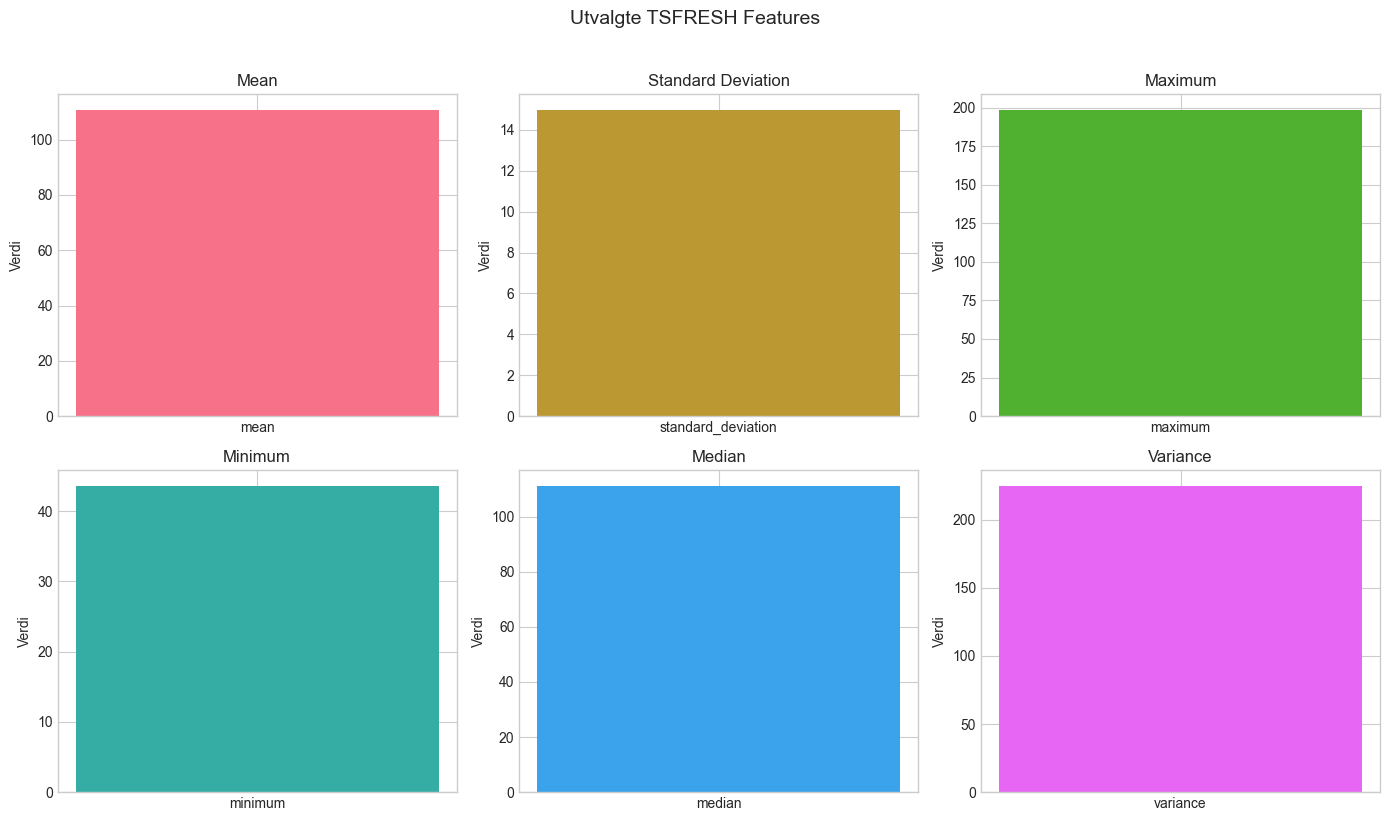


✓ Features ekstrahert og visualisert


In [12]:
# 3.4 Visualiser utvalgte features
# Velg noen interessante features for visualisering
selected_features = [
    'value__mean',
    'value__standard_deviation', 
    'value__maximum',
    'value__minimum',
    'value__median',
    'value__variance'
]

# Filtrer til features som faktisk finnes
available_features = [f for f in selected_features if f in features_efficient.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, feature in enumerate(available_features):
    ax = axes[i]
    value = features_efficient[feature].values[0]
    ax.bar([feature.replace('value__', '')], [value], color=sns.color_palette()[i])
    ax.set_title(feature.replace('value__', '').replace('_', ' ').title())
    ax.set_ylabel('Verdi')

# Skjul ubrukte subplots
for j in range(len(available_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Utvalgte TSFRESH Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Features ekstrahert og visualisert")

---
## Seksjon 4: Generer strukturert sammendrag

Her konverterer vi alle numeriske funn til et strukturert format som kan sendes til LLM:
- Tekstlige beskrivelser av trend og mønstre
- JSON-format med nøkkelstatistikk
- Oppsummering av anomalier og hendelser

In [13]:
# 4.1 Beregn trend-beskrivelse
def describe_trend(values: np.ndarray) -> dict:
    """Analyserer og beskriver trend i dataene."""
    # Lineær regresjon for trend
    x = np.arange(len(values))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, values)
    
    # Klassifiser trend
    if abs(slope) < 0.01:
        trend_type = "flat"
        trend_description = "ingen tydelig trend"
    elif slope > 0:
        trend_type = "increasing"
        trend_description = f"økende trend (+{slope:.3f} per tidsenhet)"
    else:
        trend_type = "decreasing"
        trend_description = f"synkende trend ({slope:.3f} per tidsenhet)"
    
    return {
        "type": trend_type,
        "slope": round(slope, 4),
        "r_squared": round(r_value**2, 4),
        "description": trend_description
    }

# Analyser trend
trend_info = describe_trend(df_daily['daily_mean'].dropna().values)
print("Trend-analyse:")
print(json.dumps(trend_info, indent=2, ensure_ascii=False))

Trend-analyse:
{
  "type": "increasing",
  "slope": 0.2208,
  "r_squared": 0.4163,
  "description": "økende trend (+0.221 per tidsenhet)"
}


In [14]:
# 4.2 Beskriv sesongmønster
def describe_seasonality(df: pd.DataFrame) -> dict:
    """Analyserer og beskriver sesongmønstre i dataene."""
    df_temp = df.copy()
    df_temp['hour'] = df_temp['timestamp'].dt.hour
    df_temp['dayofweek'] = df_temp['timestamp'].dt.dayofweek
    df_temp['is_weekend'] = df_temp['dayofweek'] >= 5
    
    # Daglig mønster
    hourly_mean = df_temp.groupby('hour')['value'].mean()
    peak_hour = hourly_mean.idxmax()
    low_hour = hourly_mean.idxmin()
    daily_amplitude = hourly_mean.max() - hourly_mean.min()
    
    # Ukentlig mønster
    weekend_mean = df_temp[df_temp['is_weekend']]['value'].mean()
    weekday_mean = df_temp[~df_temp['is_weekend']]['value'].mean()
    weekend_diff = weekend_mean - weekday_mean
    
    return {
        "daily_pattern": {
            "peak_hour": int(peak_hour),
            "low_hour": int(low_hour),
            "amplitude": round(daily_amplitude, 2),
            "description": f"Høyest aktivitet kl. {peak_hour}:00, lavest kl. {low_hour}:00"
        },
        "weekly_pattern": {
            "weekday_mean": round(weekday_mean, 2),
            "weekend_mean": round(weekend_mean, 2),
            "weekend_difference": round(weekend_diff, 2),
            "description": f"Helg er {'lavere' if weekend_diff < 0 else 'høyere'} enn ukedager ({abs(weekend_diff):.1f} enheter)"
        }
    }

# Analyser sesongmønster
seasonality_info = describe_seasonality(df_raw)
print("Sesongmønster-analyse:")
print(json.dumps(seasonality_info, indent=2, ensure_ascii=False))

Sesongmønster-analyse:
{
  "daily_pattern": {
    "peak_hour": 12,
    "low_hour": 23,
    "amplitude": 30.64,
    "description": "Høyest aktivitet kl. 12:00, lavest kl. 23:00"
  },
  "weekly_pattern": {
    "weekday_mean": 115.06,
    "weekend_mean": 100.59,
    "weekend_difference": -14.48,
    "description": "Helg er lavere enn ukedager (14.5 enheter)"
  }
}


In [15]:
# 4.3 Generer komplett strukturert sammendrag
def generate_structured_summary(
    df_raw: pd.DataFrame,
    df_daily: pd.DataFrame,
    features: pd.DataFrame,
    anomalies: pd.DataFrame,
    trend_info: dict,
    seasonality_info: dict
) -> dict:
    """
    Genererer et komplett strukturert sammendrag av tidsserieanalysen.
    Dette er formatet som sendes til LLM.
    """
    
    # Grunnleggende statistikk
    basic_stats = {
        "period": {
            "start": df_raw['timestamp'].min().isoformat(),
            "end": df_raw['timestamp'].max().isoformat(),
            "duration_days": (df_raw['timestamp'].max() - df_raw['timestamp'].min()).days
        },
        "data_points": len(df_raw),
        "sampling_frequency": "hourly"
    }
    
    # Nøkkeltall
    key_statistics = {
        "mean": round(df_raw['value'].mean(), 2),
        "std": round(df_raw['value'].std(), 2),
        "min": round(df_raw['value'].min(), 2),
        "max": round(df_raw['value'].max(), 2),
        "median": round(df_raw['value'].median(), 2),
        "range": round(df_raw['value'].max() - df_raw['value'].min(), 2)
    }
    
    # Anomali-informasjon
    anomaly_summary = {
        "count": len(anomalies),
        "dates": [ts.isoformat() for ts in anomalies['timestamp'].tolist()],
        "values": [round(v, 2) for v in anomalies['value'].tolist()],
        "description": f"Funnet {len(anomalies)} datapunkter med uvanlig høye eller lave verdier"
    }
    
    # TSFRESH features (utvalgte)
    tsfresh_summary = {}
    for col in features.columns:
        clean_name = col.replace('value__', '')
        tsfresh_summary[clean_name] = round(features[col].values[0], 4)
    
    return {
        "metadata": basic_stats,
        "key_statistics": key_statistics,
        "trend": trend_info,
        "seasonality": seasonality_info,
        "anomalies": anomaly_summary,
        "tsfresh_features": tsfresh_summary
    }

# Generer sammendrag
analysis_summary = generate_structured_summary(
    df_raw, df_daily, features_minimal, detected_anomalies, trend_info, seasonality_info
)

print("Strukturert sammendrag generert:")
print(json.dumps(analysis_summary, indent=2, ensure_ascii=False))

Strukturert sammendrag generert:
{
  "metadata": {
    "period": {
      "start": "2025-01-01T00:00:00",
      "end": "2025-03-31T23:00:00",
      "duration_days": 89
    },
    "data_points": 2160,
    "sampling_frequency": "hourly"
  },
  "key_statistics": {
    "mean": 110.88,
    "std": 15.0,
    "min": 43.6,
    "max": 198.66,
    "median": 111.18,
    "range": 155.06
  },
  "trend": {
    "type": "increasing",
    "slope": 0.2208,
    "r_squared": 0.4163,
    "description": "økende trend (+0.221 per tidsenhet)"
  },
  "seasonality": {
    "daily_pattern": {
      "peak_hour": 12,
      "low_hour": 23,
      "amplitude": 30.64,
      "description": "Høyest aktivitet kl. 12:00, lavest kl. 23:00"
    },
    "weekly_pattern": {
      "weekday_mean": 115.06,
      "weekend_mean": 100.59,
      "weekend_difference": -14.48,
      "description": "Helg er lavere enn ukedager (14.5 enheter)"
    }
  },
  "anomalies": {
    "count": 13,
    "dates": [
      "2025-01-01T23:00:00",
      "20

In [16]:
# 4.4 Generer tekstlig sammendrag (for LLM-prompt)
def generate_text_summary(summary: dict) -> str:
    """
    Konverterer strukturert sammendrag til naturlig tekst
    som kan brukes i en LLM-prompt.
    """
    text = f"""
TIDSSERIEANALYSE - SAMMENDRAG

DATAPERIODE:
- Fra: {summary['metadata']['period']['start'][:10]}
- Til: {summary['metadata']['period']['end'][:10]}
- Varighet: {summary['metadata']['period']['duration_days']} dager
- Antall datapunkter: {summary['metadata']['data_points']} (målt {summary['metadata']['sampling_frequency']})

NØKKELSTATISTIKK:
- Gjennomsnitt: {summary['key_statistics']['mean']}
- Standardavvik: {summary['key_statistics']['std']}
- Minimum: {summary['key_statistics']['min']}
- Maksimum: {summary['key_statistics']['max']}
- Spredning (range): {summary['key_statistics']['range']}

TRENDANALYSE:
- Type: {summary['trend']['type']}
- Beskrivelse: {summary['trend']['description']}
- R² (forklaringsgrad): {summary['trend']['r_squared']}

SESONGMØNSTRE:
Daglig mønster:
- {summary['seasonality']['daily_pattern']['description']}
- Amplitude: {summary['seasonality']['daily_pattern']['amplitude']} enheter

Ukentlig mønster:
- {summary['seasonality']['weekly_pattern']['description']}
- Ukedager snitt: {summary['seasonality']['weekly_pattern']['weekday_mean']}
- Helg snitt: {summary['seasonality']['weekly_pattern']['weekend_mean']}

ANOMALIER:
- {summary['anomalies']['description']}
- Antall: {summary['anomalies']['count']}
"""
    return text.strip()

# Generer tekstsammendrag
text_summary = generate_text_summary(analysis_summary)
print(text_summary)

TIDSSERIEANALYSE - SAMMENDRAG

DATAPERIODE:
- Fra: 2025-01-01
- Til: 2025-03-31
- Varighet: 89 dager
- Antall datapunkter: 2160 (målt hourly)

NØKKELSTATISTIKK:
- Gjennomsnitt: 110.88
- Standardavvik: 15.0
- Minimum: 43.6
- Maksimum: 198.66
- Spredning (range): 155.06

TRENDANALYSE:
- Type: increasing
- Beskrivelse: økende trend (+0.221 per tidsenhet)
- R² (forklaringsgrad): 0.4163

SESONGMØNSTRE:
Daglig mønster:
- Høyest aktivitet kl. 12:00, lavest kl. 23:00
- Amplitude: 30.64 enheter

Ukentlig mønster:
- Helg er lavere enn ukedager (14.5 enheter)
- Ukedager snitt: 115.06
- Helg snitt: 100.59

ANOMALIER:
- Funnet 13 datapunkter med uvanlig høye eller lave verdier
- Antall: 13


---
## Seksjon 5: LLM-integrasjon

Nå sender vi det strukturerte sammendraget til OpenAI for å få en naturlig språk-forklaring.

**Viktig**: Sett OPENAI_API_KEY som miljøvariabel før du kjører denne seksjonen.

In [20]:
# 5.1 Konfigurasjon - Last API-nøkkel fra .env fil
import os
from pathlib import Path
from dotenv import load_dotenv

# Finn og last .env fil (søker i current dir og parent dirs)
env_path = Path('.env')
if not env_path.exists():
    # Søk i parent directories
    for parent in Path.cwd().parents:
        potential_env = parent / '.env'
        if potential_env.exists():
            env_path = potential_env
            break

# Last miljøvariabler fra .env
load_dotenv(dotenv_path=env_path)

# Hent API-nøkkel
api_key = os.environ.get('OPENAI_API_KEY')

if api_key:
    print(f"✓ OPENAI_API_KEY lastet fra: {env_path.absolute()}")
    client = OpenAI(api_key=api_key)
else:
    print("⚠ OPENAI_API_KEY ikke funnet")
    print("  Opprett en .env fil med innhold:")
    print("  OPENAI_API_KEY=din-api-nøkkel")
    client = None

✓ OPENAI_API_KEY lastet fra: c:\Users\kevin\Documents\GitHub\NL-to-Graphql\Tidsserie analyse\jupyter_pipeline\.env


In [21]:
# 5.2 Definer prompt-maler for ulike bruksscenarier

PROMPT_TEMPLATES = {
    "general_explanation": """
Du er en erfaren dataanalytiker som forklarer komplekse analyser for ikke-tekniske brukere.

Basert på følgende tidsserieanalyse, gi en klar og lettfattelig forklaring på norsk.
Fokuser på:
1. Hva dataene viser overordnet
2. Viktige mønstre og trender
3. Uvanlige hendelser (anomalier)
4. Hva dette kan bety i praksis

ANALYSEDATA:
{analysis_text}

Gi en forklaring som en leder eller beslutningstaker kan forstå uten teknisk bakgrunn.
""",
    
    "technical_summary": """
Du er en senior data scientist. Gi et teknisk sammendrag av følgende tidsserieanalyse.

ANALYSEDATA:
{analysis_text}

Inkluder:
1. Statistiske karakteristikker
2. Signifikante mønstre
3. Metodologiske observasjoner
4. Anbefalinger for videre analyse
""",
    
    "business_insights": """
Du er en forretningsanalytiker. Basert på følgende tidsseriedata, identifiser 
forretningsmessige innsikter og handlingsanbefalinger.

ANALYSEDATA:
{analysis_text}

Strukturer svaret ditt som:
1. Nøkkelinnsikter (3-5 punkter)
2. Potensielle årsaker
3. Anbefalte tiltak
4. Risikofaktorer å følge med på
"""
}

print("Prompt-maler definert:")
for name in PROMPT_TEMPLATES:
    print(f"  - {name}")

Prompt-maler definert:
  - general_explanation
  - technical_summary
  - business_insights


In [22]:
# 5.3 Funksjon for å kalle LLM
def get_llm_explanation(
    analysis_text: str,
    prompt_type: str = "general_explanation",
    model: str = "gpt-4o-mini"
) -> str:
    """
    Sender analyse til OpenAI og får tilbake en forklaring.
    
    Parametere:
    -----------
    analysis_text : str
        Det tekstlige sammendraget av analysen
    prompt_type : str
        Type prompt å bruke (general_explanation, technical_summary, business_insights)
    model : str
        OpenAI modell å bruke
    
    Returns:
    --------
    str: LLM-generert forklaring
    """
    if client is None:
        return "❌ Kan ikke kalle LLM - OPENAI_API_KEY ikke konfigurert"
    
    prompt = PROMPT_TEMPLATES[prompt_type].format(analysis_text=analysis_text)
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Du er en hjelpsom assistent som forklarer dataanalyse på norsk."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=1000
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"❌ Feil ved API-kall: {str(e)}"

print("LLM-funksjon definert")

LLM-funksjon definert


In [23]:
# 5.4 Test: Generell forklaring
print("=" * 60)
print("GENERELL FORKLARING FOR IKKE-TEKNISKE BRUKERE")
print("=" * 60)

general_explanation = get_llm_explanation(text_summary, "general_explanation")
print(general_explanation)

GENERELL FORKLARING FOR IKKE-TEKNISKE BRUKERE
Selvfølgelig! Her er en lettfattelig forklaring av tidsserieanalysen basert på de oppgitte dataene:

### 1. Hva dataene viser overordnet
Dataene dekker en periode på 89 dager fra 1. januar til 31. mars 2025, hvor vi har målt aktiviteten time for time. Gjennomsnittlig aktivitet i denne perioden er 110.88 enheter, noe som gir oss et godt inntrykk av det generelle nivået. Vi har identifisert både høyeste og laveste aktivitet, med maksimum på 198.66 enheter og minimum på 43.6 enheter.

### 2. Viktige mønstre og trender
Analysen viser en **økt trend** i aktiviteten over tid, med en gjennomsnittlig vekst på 0.221 enheter for hver time. Dette indikerer at aktiviteten generelt øker, noe som kan være et positivt tegn for virksomheten. 

Når vi ser på **daglige mønstre**, oppdager vi at aktiviteten når sitt høydepunkt rundt kl. 12:00 og er lavest ved 23:00, med en variasjon på omtrent 30.64 enheter mellom disse tidene. I tillegg ser vi at aktiviteten

In [24]:
# 5.5 Test: Teknisk sammendrag
print("=" * 60)
print("TEKNISK SAMMENDRAG FOR DATA SCIENTISTS")
print("=" * 60)

technical_summary = get_llm_explanation(text_summary, "technical_summary")
print(technical_summary)

TEKNISK SAMMENDRAG FOR DATA SCIENTISTS
### Teknisk Sammendrag av Tidsserieanalyse

#### 1. Statistiske Karakteristikker
- **Dataperiode**: Analysen omfatter en tidsperiode fra 1. januar 2025 til 31. mars 2025, totalt 89 dager, med 2160 datapunkter målt på en timebasis.
- **Nøkkelstatistikk**:
  - **Gjennomsnitt**: 110.88, som gir et indikasjon på den generelle nivået av de målte verdiene.
  - **Standardavvik**: 15.0, som viser variasjonen rundt gjennomsnittet.
  - **Minimum**: 43.6, og **Maksimum**: 198.66, som viser spredningen i dataene.
  - **Spredning (Range)**: 155.06, som er forskjellen mellom maksimum og minimum.

#### 2. Signifikante Mønstre
- **Trend**: Det er identifisert en økende trend i dataene med en økning på +0.221 per tidsenhet. Forklaringsgraden (R²) for denne trenden er 0.4163, noe som indikerer at omtrent 41.63% av variasjonen i dataene kan forklares av den identifiserte trenden.
  
- **Sesongmønstre**:
  - **Daglig Mønster**: Aktiviteten er høyest kl. 12:00 og lave

In [25]:
# 5.6 Test: Forretningsmessige innsikter
print("=" * 60)
print("FORRETNINGSMESSIGE INNSIKTER")
print("=" * 60)

business_insights = get_llm_explanation(text_summary, "business_insights")
print(business_insights)

FORRETNINGSMESSIGE INNSIKTER
### 1. Nøkkelinnsikter
- **Økende Trend**: Det er en klar økning i aktivitet over tidsperioden, med en gjennomsnittlig økning på 0.221 enheter per time, som tyder på en positiv utvikling for virksomheten.
- **Daglig Aktivitetssyklus**: Aktiviteten topper seg rundt kl. 12:00, noe som indikerer at dette er det mest gunstige tidspunktet for tiltak og markedsføring.
- **Ukentlig Mønster**: Aktiviteten er høyere på ukedager sammenlignet med helgene, noe som kan påvirke ressursallokeringen.
- **Variabilitet**: Det er en høy spredning i dataene (155.06), noe som tyder på betydelig variasjon i aktivitet, som kan indikere både muligheter og utfordringer.
- **Anomalier**: Det er registrert 13 datapunkter med uvanlige verdier, noe som kan indikere enten feil i datainnsamlingen eller ekstraordinære hendelser som bør undersøkes nærmere.

### 2. Potensielle årsaker
- Den økende trenden kan skyldes flere faktorer, inkludert økt etterspørsel, forbedret markedsføring, eller

---
## Konklusjon og neste steg

Denne notebooken har demonstrert den grunnleggende flyten fra rå tidsseriedata til LLM-genererte forklaringer:

1. **Syntetisk data** ble generert med realistiske mønstre (trend, sesong, anomalier)
2. **Deterministisk prosessering** (resampling, rullende statistikk, change point detection)
3. **TSFRESH feature extraction** for automatisk ekstraksjon av tidsseriefeatures
4. **Strukturerte sammendrag** i både JSON og tekstformat
5. **LLM-integrasjon** med ulike prompt-strategier for ulike målgrupper

### Neste steg for videre utforskning:
- Teste med ekte tidsseriedata (aksjer, IoT-sensorer, etc.)
- Eksperimentere med mer avanserte feature extraction-parametere
- Implementere prediksjonsmodeller (nivå 2)
- Legge til interaktiv dialog med LLM for oppfølgingsspørsmål

In [ ]:
# Komplett pipeline-funksjon for gjenbruk
def run_timeseries_llm_pipeline(
    df: pd.DataFrame = None,
    timestamp_col: str = 'timestamp',
    value_col: str = 'value',
    prompt_type: str = 'general_explanation'
) -> dict:
    """
    Kjører hele pipelinen fra data til LLM-forklaring.
    
    Parametere:
    -----------
    df : pd.DataFrame
        Input dataframe. Hvis None, genereres syntetisk data.
    timestamp_col : str
        Navn på timestamp-kolonnen
    value_col : str
        Navn på verdi-kolonnen
    prompt_type : str
        Type LLM-prompt å bruke
    
    Returns:
    --------
    dict med alle analysresultater og LLM-forklaring
    """
    # Generer data hvis ikke gitt
    if df is None:
        df, _ = generate_synthetic_timeseries()
        timestamp_col = 'timestamp'
        value_col = 'value'
    
    # Kopier og standardiser
    df_work = df[[timestamp_col, value_col]].copy()
    df_work.columns = ['timestamp', 'value']
    df_work['id'] = 1
    
    # Prosessering
    df_indexed = df_work.set_index('timestamp')
    df_daily = df_indexed['value'].resample('D').agg(['mean', 'std', 'min', 'max'])
    df_daily.columns = ['daily_mean', 'daily_std', 'daily_min', 'daily_max']
    
    # Anomalideteksjon
    df_work['z_score'] = stats.zscore(df_work['value'])
    df_work['is_anomaly'] = np.abs(df_work['z_score']) > 2.5
    anomalies = df_work[df_work['is_anomaly']]
    
    # TSFRESH
    df_tsfresh = df_work[['id', 'timestamp', 'value']].copy()
    df_tsfresh.columns = ['id', 'time', 'value']
    df_tsfresh['time'] = (df_tsfresh['time'] - df_tsfresh['time'].min()).dt.total_seconds()
    features = extract_features(
        df_tsfresh, column_id='id', column_sort='time', column_value='value',
        default_fc_parameters=MinimalFCParameters(), disable_progressbar=True
    )
    
    # Analyser
    trend_info = describe_trend(df_daily['daily_mean'].dropna().values)
    seasonality_info = describe_seasonality(df_work)
    
    # Generer sammendrag
    summary = generate_structured_summary(
        df_work, df_daily, features, anomalies, trend_info, seasonality_info
    )
    text_summary = generate_text_summary(summary)
    
    # LLM forklaring
    llm_explanation = get_llm_explanation(text_summary, prompt_type)
    
    return {
        'summary': summary,
        'text_summary': text_summary,
        'llm_explanation': llm_explanation,
        'features': features,
        'anomalies': anomalies
    }

print("✓ Pipeline-funksjon definert og klar til bruk!")
print("\nEksempel bruk:")
print("  results = run_timeseries_llm_pipeline()")
print("  print(results['llm_explanation'])")